# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [2]:
from datetime import datetime

import pandas as pd
from pandas.io.json import json_normalize

import matplotlib.pyplot as plt
import numpy as np
import math
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import json
% matplotlib inline

In [3]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

#  Data Clean-up

## Portfolio

portfolio.json

- id (string) - offer id
- offer_type (string) - type of offer ie BOGO, discount, informational
- difficulty (int) - minimum required spend to complete an offer
- reward (int) - reward given for completing an offer
- duration (int) - time for offer to be open, in days
- channels (list of strings)

In [4]:
portfolio['is_web'] = portfolio.channels.str.contains('web', na=False, regex=False) 
portfolio['is_social'] = portfolio.channels.str.contains('social', na=False, regex=False)
portfolio['is_email'] = portfolio.channels.str.contains('email', na=False, regex=False)
portfolio['is_mobile'] = portfolio.channels.str.contains('mobile', na=False, regex=False)

In [5]:
# dropping the original 'channels' column
portfolio = portfolio.drop(['channels'], axis=1)

## Profile

profile.json

- age (int) - age of the customer
- became_member_on (int) - date when customer created an app account
- gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
- id (str) - customer id
- income (float) - customer's income

In [6]:
# Replacing None with NaN
profile['gender'] = profile.gender.replace([None], np.nan)

In [7]:
# Turning became_member_on field into a date format
profile['became_member_on'] = pd.to_datetime(profile.became_member_on, format='%Y%m%d')

In [8]:
# Adding a column for customer age in days
profile['length_of_stay_in_days'] = (datetime.today() - profile['became_member_on']).dt.days

## Transcript

transcript.json
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [9]:
# turning the key-value pair in 'value' column as separate df columns
value_normalized = json_normalize(transcript['value'])

# coalescing the duplicated offer id/offer_id columns
value_normalized['offer_id'] = value_normalized['offer id'].fillna(value_normalized['offer_id'])

# merging value_normalized with the original transcript
transcript = transcript.merge(value_normalized, left_index=True, right_index=True)

# deleting the original 'value' column
transcript = transcript.drop(['value', 'offer id'], axis=1)

In [10]:
transcript.head()

,event,person,time,amount,offer_id,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


### Computing Offer Success

In [11]:
agg_transcript = (transcript.groupby(['person','offer_id','event']).count()['time'].unstack()).reset_index()
agg_transcript.fillna(0.0, inplace = True)

In [12]:
# those that completed offer and viewed the offer will be marked as successful offer
conditions = [
    (agg_transcript['offer completed'] >= 1) & (agg_transcript['offer viewed'] >= 1)
]

agg_transcript['offer successful'] = np.select(conditions, [1], default=0)


In [13]:
# dropping the old columns of offer completed, offer viewed and offer received
persons_offer_success_status = agg_transcript.drop(
    ['offer completed', 'offer viewed', 'offer received'], axis=1
)

In [14]:
persons_offer_success_status.head()

event,person,offer_id,offer successful
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1


# Exploratory Data Analysis

In [15]:
portfolio.head(2)

,difficulty,duration,id,offer_type,reward,is_web,is_social,is_email,is_mobile
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,False,True,True,True
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,True,True,True,True


In [16]:
transcript.head(2)

,event,person,time,amount,offer_id,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN


In [17]:
profile.head(2)

,age,became_member_on,gender,id,income,length_of_stay_in_days
0,118,2017-02-12,NaN,68be06ca386d4c31939f3a4f0e3dd783,NaN,1673
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,1520


## Portfolio Types

Breakdown by offer type

In [18]:
# finding the number of offers by offer_type
portfolio.groupby(by=['offer_type']).size().sort_values(ascending=False)

offer_type
discount         4
bogo             4
informational    2
dtype: int64

## Event Transcript

In [19]:
# finding the number of offer transcript by event
count_by_event = transcript.groupby(by=['event']).size().sort_values(ascending=False).reset_index()

# assigning column names to the newly-created df
count_by_event.columns = ['event', 'count']

# calculating percent of total for each event 
count_by_event['percent_of_total'] = \
    round(
        (count_by_event['count'] / count_by_event['count'].sum()) * 100,
        2
    )

count_by_event.head()

,event,count,percent_of_total
0,transaction,138953,45.33
1,offer received,76277,24.88
2,offer viewed,57725,18.83
3,offer completed,33579,10.95


**Interpretation**

Most of the events are transactions, followed by offer received, viewed and completed.

## Customer's Age Distribution

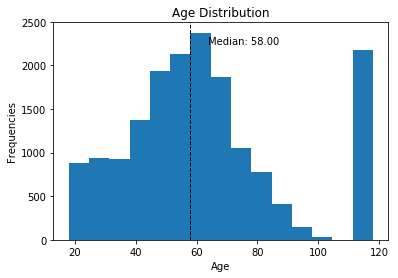

In [20]:
cust_age_median = profile['age'].median()

# Income distribution of the profiles (histogram)
ax = profile['age'].plot(
    kind='hist',
    lw=2,
    bins=15,
    title='Age Distribution'
)

plt.axvline(cust_age_median, color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(cust_age_median * 1.1, max_ylim * 0.9, 'Median: {:.2f}'.format(cust_age_median))

ax.set_xlabel('Age')
ax.set_ylabel('Frequencies');

**Interpretation**

It looks like Starbucks is well-received across different age groups. However, it can be seen that most of Starbucks customers comprise of those between the age of 55–65 years old. It is also possible that users are not inputting their real age when they filled in their information.

In [21]:
## NOT SURE WHAT HAPPENED HERE?

(profile[profile['gender']=='M']['age']).dtype

dtype('int64')

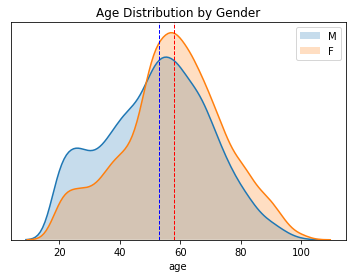

In [22]:
male_cust_age_median = (profile[profile['gender'] == 'M']['age']).median()
female_cust_age_median = (profile[profile['gender'] == 'F']['age']).median()

# KDE plot for male age distribution
sns.distplot(
    profile[profile['gender']=='M']['age'],
    kde_kws={"shade": True},
    hist=False
);

# KDE plot for female age distribution
sns.distplot(
    profile[profile['gender']=='F']['age'],
    kde_kws={"shade": True},
    hist=False
);

# Add legend and title
plt.legend(['M', 'F'])
plt.title('Age Distribution by Gender');

# Add Median Line
plt.axvline(male_cust_age_median, color='b', linestyle='dashed', linewidth=1)
plt.axvline(female_cust_age_median, color='r', linestyle='dashed', linewidth=1)

# Hide y-axis of the plot
y_axis = plt.gca().get_yaxis()
y_axis.set_visible(False)

**Interpretation**

The distribuition of age across both genders is almost identical. 

## Customers' Income Distribution

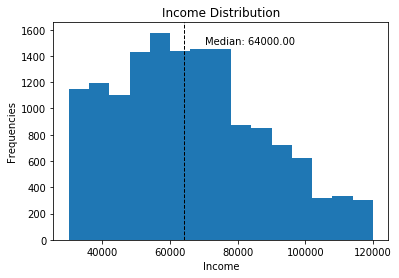

In [23]:
income_median = profile['income'].median()

# Income distribution of the profiles (histogram)
ax = profile['income'].plot(
    kind='hist',
    lw=2,
    bins=15,
    title='Income Distribution'
)

plt.axvline(income_median, color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(income_median * 1.1, max_ylim * 0.9, 'Median: {:.2f}'.format(income_median))

ax.set_xlabel('Income')
ax.set_ylabel('Frequencies');

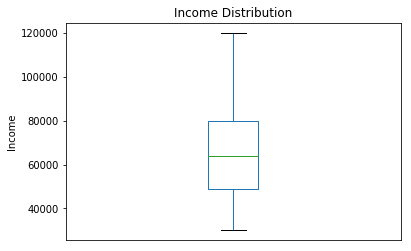

In [24]:
# Income distribution of the profiles (boxplot)
ax = profile['income'].plot(
    kind='box',
    title='Income Distribution'
)
ax.set_ylabel('Income');

# Remove default x-axis
x_axis = ax.axes.get_xaxis()
x_axis.set_visible(False)
plt.show;

**Interpretation**

[The U.S. Census Bureau](https://fred.stlouisfed.org/series/MEPAINUSA672N#0)
lists the annual real median personal income at 35,977 USD in 2019. Based on the sample data that we have, 50% of Starbucks customers (identified through the Interquartile Range) are earning above the median income for the US, ranging from 50,000 - 80,000 USD, with a median of around 65,000 USD.

In [25]:
## Not su
(profile[profile['gender']=='M']['income']).dtype

dtype('float64')

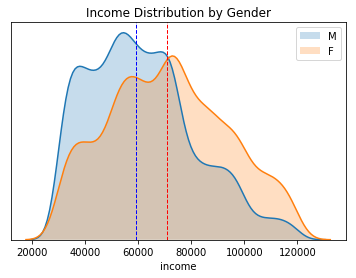

In [26]:
male_income_median = (profile[profile['gender'] == 'M']['income']).median()
female_income_median = (profile[profile['gender'] == 'F']['income']).median()

# KDE plot for male income distribution
sns.distplot(
    profile[profile['gender']=='M']['income'],
    kde_kws={"shade": True},
    hist=False
);

# KDE plot for female income distribution
sns.distplot(
    profile[profile['gender']=='F']['income'],
    kde_kws={"shade": True},
    hist=False
);

# Hide y-axis of the plot
y_axis = plt.gca().get_yaxis()
y_axis.set_visible(False)

# Add legend and title
plt.legend(['M', 'F'])
plt.title('Income Distribution by Gender');

# Add Median Line
plt.axvline(male_income_median, color='b', linestyle='dashed', linewidth=1)
plt.axvline(female_income_median, color='r', linestyle='dashed', linewidth=1)

**Interpretation**

Income distribution seems to differ by gender. The distribution among male customers is left skewed, whereas the distribution among female customers looks to be more evenly distributed. From the kdt plot above, we can also see that female customers in the dataset are earning higher than their male counterpart.

## Customers' 'Length of Stay' Distribution

In [27]:
# finding the number of offer transcript by event
count_by_gender = profile.groupby(by=['gender']).size().sort_values(ascending=False).reset_index()

# assigning column names to the newly-created df
count_by_gender.columns = ['gender', 'count']

# calculating percent of total for each event 
count_by_gender['percent_of_total'] = \
    round(
        (count_by_gender['count'] / count_by_gender['count'].sum()) * 100,
        2
    )

count_by_gender.head()

,gender,count,percent_of_total
0,M,8484,57.23
1,F,6129,41.34
2,O,212,1.43


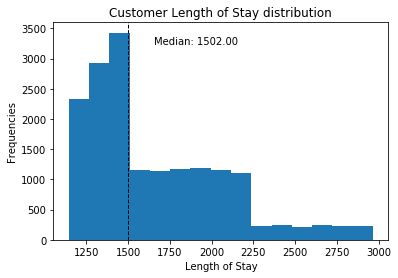

In [28]:
# Customer length of stay distribution

length_of_stay_median = profile['length_of_stay_in_days'].median()

ax = profile['length_of_stay_in_days'].plot(
    kind='hist',
    lw=2,
    bins=15,
    title='Customer Length of Stay distribution'
)

plt.axvline(length_of_stay_median, color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(length_of_stay_median * 1.1, max_ylim * 0.9, 'Median: {:.2f}'.format(length_of_stay_median))

ax.set_xlabel('Length of Stay')
ax.set_ylabel('Frequencies');

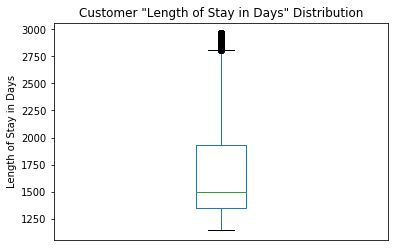

In [29]:
# Length of Stay distribution of the profiles (boxplot)
ax = profile['length_of_stay_in_days'].plot(
    kind='box',
    title='Customer "Length of Stay in Days" Distribution'
)

ax.set_ylabel('Length of Stay in Days');

# Remove default x-axis
x_axis = ax.axes.get_xaxis()
x_axis.set_visible(False)
plt.show;

**Interpretation**

The result of customers age is quite left-skewed. 50% of the customers have been with Starbucks for around 1315 - 1875 days, or 3.6 - 5.13 years. The median of the Customer "Age" is slightly below 1500 days, or 4.1 years.

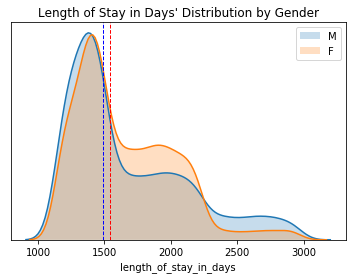

In [30]:
male_length_of_stay = (profile[profile['gender'] == 'M']['length_of_stay_in_days']).median()
female_length_of_stay = (profile[profile['gender'] == 'F']['length_of_stay_in_days']).median()

# KDE plot for male length of stay
sns.distplot(
    profile[profile['gender']=='M']['length_of_stay_in_days'],
    kde_kws={"shade": True},
    hist=False
);

# KDE plot for female length of stay
sns.distplot(
    profile[profile['gender']=='F']['length_of_stay_in_days'],
    kde_kws={"shade": True},
    hist=False
);

# Hide y-axis of the plot
y_axis = plt.gca().get_yaxis()
y_axis.set_visible(False)

# Add legend and title
plt.legend(['M', 'F'])
plt.title("Length of Stay in Days' Distribution by Gender");

# Add Median Line
plt.axvline(male_length_of_stay, color='b', linestyle='dashed', linewidth=1)
plt.axvline(female_length_of_stay, color='r', linestyle='dashed', linewidth=1)

**Interpretation**

Distribution of 'length of stay in days' across both genders are almost identical.

## Transcript Count by Offer Type and Event

In [31]:
# Merging transcript and portfolio DFs
offer_transcripts = transcript.merge(right=portfolio, how='left', left_on='offer_id', right_on='id')

# Renaming duplicated 'reward' columns
offer_transcripts = offer_transcripts.rename(
    columns={
        'reward_x':'transcript_reward',
        'reward_y':'rewards',
    },
)

In [32]:
transcript_count_by_offer_type = offer_transcripts.groupby(['offer_type']).count()['person'].sort_values(ascending=False).reset_index()

# assigning column names to the newly-created df
transcript_count_by_offer_type.columns = ['offer_type', 'transcript_count']

# calculating percent of total for each offer_type 
transcript_count_by_offer_type['percent_of_total'] = \
    round(
        (transcript_count_by_offer_type['transcript_count'] / transcript_count_by_offer_type['transcript_count'].sum()) * 100,
        2
    )

transcript_count_by_offer_type.head()

,offer_type,transcript_count,percent_of_total
0,bogo,71617,42.74
1,discount,69898,41.71
2,informational,26066,15.55


**Interpretation**

Most of the transcripts received by customers are of 'BOGO' and 'Discount' offer types, only a small percentage of them are of 'Informational' offer type.

## Offer Success Across Gender

In [33]:
persons_offer_success_profile = persons_offer_success_status.merge(
    profile, how='left', left_on='person', right_on='id'
)

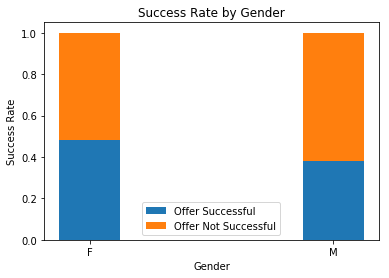

In [34]:
fig, ax = plt.subplots()

labels = ['F', 'M']
width = 0.25

# calculating offer successful rate by gender, ['M', 'F', 'O'], [:2] excluding the O
offer_successful = list(persons_offer_success_profile.groupby(['gender'])['offer successful'].mean() * 1)[:2]

# 1 - offer successful rate
offer_not_successful = [1 - x for x in offer_successful]

b1 = ax.bar(labels, offer_successful, width, label='Offer Successful')
b2 = ax.bar(labels, offer_not_successful, width, label='Offer Not Successful', bottom=offer_successful)

ax.set_ylabel('Success Rate')
ax.set_xlabel('Gender')
ax.set_title('Success Rate by Gender')
ax.legend()

plt.show();

**Interpretation**

The distribution of offer success across females customers are almost equal, whereas there are slightly fewer successful offers across male customers

In [35]:
persons_offer_success_status.head(2)

event,person,offer_id,offer successful
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0


## Merge Dataframes

Merging all 3 dataframes into 1 dataframe and one-hot encoding columns for the ML algorithm to ingest

In [36]:
profile.head(2)

,age,became_member_on,gender,id,income,length_of_stay_in_days
0,118,2017-02-12,NaN,68be06ca386d4c31939f3a4f0e3dd783,NaN,1673
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,1520


In [37]:
# Merging persons_offer_success_status (transcript of each offer for each person) and profile
persons_offer_status_with_profile = persons_offer_success_status.merge(profile, left_on='person', right_on='id')

# Dropping 'became_member_on' date field and id field (same as 'person' field which is the person id)
persons_offer_status_with_profile = persons_offer_status_with_profile.drop(['became_member_on', 'id'], axis=1)

In [38]:
# One-hot encode gender column into: gender_F, gender_M and gender_O columns
dummied_gender = pd.get_dummies(persons_offer_status_with_profile['gender'], prefix='gender')

In [39]:
# Merging the 'persons_offer_status_with_profile' df with the one-hot encoded gender columns
persons_offer_status_with_profile = pd.merge(
    persons_offer_status_with_profile,
    dummied_gender,
    left_index=True,
    right_index=True
)

In [40]:
# Merging with `persons_offer_status_with_profile` and `portfolio` columns and name it as df
df = pd.merge(persons_offer_status_with_profile, portfolio, left_on='offer_id', right_on='id')

# Dropping the id column as it is the same as offer_id column; gender column is 
# also dropped as we have included the one-hot encoded column
df.drop(['id', 'gender'], axis=1, inplace=True)

In [41]:
# One-hot encoding of the social media booleans columns
offer_channel_columns_list = ['is_web', 'is_social', 'is_email',  'is_mobile']

dummied_offer_channels = df[offer_channel_columns_list] * 1

In [42]:
# Dropping the original offer channel booleans columns before merging
df = df.drop(dummied_offer_channels, axis=1)

# Merging the 'persons_offer_status_with_profile' df with the one-hot encoded gender columns
df = pd.merge(
    df,
    dummied_offer_channels,
    left_index=True,
    right_index=True
)

In [43]:
# One-hot encode 'offer_type' column into: is_offer_bogo, is_offer_discount and is_offer_informational columns
dummied_offer_types = pd.get_dummies(df['offer_type'], prefix='is_offer')

In [44]:
df.drop(['offer_type'], axis=1, inplace=True)

In [45]:
df.head(8)

,person,offer_id,offer successful,age,income,length_of_stay_in_days,gender_F,gender_M,gender_O,difficulty,duration,reward,is_web,is_social,is_email,is_mobile
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,0,33,72000.0,1605,0,1,0,10,7,2,1,0,1,1
1,00426fe3ffde4c6b9cb9ad6d077a13ea,2906b810c7d4411798c6938adc9daaa5,0,19,65000.0,1860,1,0,0,10,7,2,1,0,1,1
2,005500a7188546ff8a767329a2f7c76a,2906b810c7d4411798c6938adc9daaa5,0,56,47000.0,1373,0,1,0,10,7,2,1,0,1,1
3,0069a50874d846438e58acff5e594725,2906b810c7d4411798c6938adc9daaa5,1,118,NaN,1958,0,0,0,10,7,2,1,0,1,1
4,00715b6e55c3431cb56ff7307eb19675,2906b810c7d4411798c6938adc9daaa5,1,58,119000.0,1375,1,0,0,10,7,2,1,0,1,1
5,00840a2ca5d2408e982d56544dc14ffd,2906b810c7d4411798c6938adc9daaa5,1,26,61000.0,2457,0,1,0,10,7,2,1,0,1,1
6,008d7088107b468893889da0ede0df5c,2906b810c7d4411798c6938adc9daaa5,0,24,42000.0,1463,0,1,0,10,7,2,1,0,1,1
7,0092a132ead946ceb30d11a1ed513d20,2906b810c7d4411798c6938adc9daaa5,0,118,NaN,1229,0,0,0,10,7,2,1,0,1,1


## Dealing with missing values and anomalies

In [46]:
# Returning a df with at least 1 NaN value in any column
null_values = df[df.isnull().any(axis=1)]
null_values.head()

,person,offer_id,offer successful,age,income,length_of_stay_in_days,gender_F,gender_M,gender_O,difficulty,duration,reward,is_web,is_social,is_email,is_mobile
3,0069a50874d846438e58acff5e594725,2906b810c7d4411798c6938adc9daaa5,1,118,NaN,1958,0,0,0,10,7,2,1,0,1,1
7,0092a132ead946ceb30d11a1ed513d20,2906b810c7d4411798c6938adc9daaa5,0,118,NaN,1229,0,0,0,10,7,2,1,0,1,1
9,009d10c2c38a4fd795a7bc6ddbbddb78,2906b810c7d4411798c6938adc9daaa5,0,118,NaN,1173,0,0,0,10,7,2,1,0,1,1
12,00b5fb9d842d437e83033ad9e36f7148,2906b810c7d4411798c6938adc9daaa5,0,118,NaN,1324,0,0,0,10,7,2,1,0,1,1
28,0155a21497d54684a55c3bc609843768,2906b810c7d4411798c6938adc9daaa5,0,118,NaN,1986,0,0,0,10,7,2,1,0,1,1


**Interpretation**

It looks like there are a lot of NaNs in the income column. It looks like these people who have NaN values for income did not specify any gender

In [47]:
# Checking the number of rows that have at least 1 NaN value in any column
print(len(null_values));

8066


In [48]:
# Surprisingly, those people who have NaN values for income put 118 as their age
null_values['age'].unique()

array([118])

In [49]:
# Calculating the proportion of the df that has at least 1 NaN in any of its columns 
len(null_values) / len(df)

0.12744912147642523

**Interpretation**

This makes up 12% of the data. Keeping them would throw off accuracy of our prediction and therefore I chose to discard these rows. Usually, other methods such as imputation can be considered to fill in the NaN values. However, NaN values are not the only problem that those records have. The other columns in the records do not seem to have an accurate data. E.g. Age 118 is unusual; no gender specified.

# Feature Engineering

In [50]:
# Dropping the rows that contain at least 1 NaN values
df.dropna(axis=0, how='any', inplace=True)

In [51]:
# Length of the dataframe after dropping the NaN values
len(df)

55222

## Split into train and test dataset

In [52]:
df.head()

,person,offer_id,offer successful,age,income,length_of_stay_in_days,gender_F,gender_M,gender_O,difficulty,duration,reward,is_web,is_social,is_email,is_mobile
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,0,33,72000.0,1605,0,1,0,10,7,2,1,0,1,1
1,00426fe3ffde4c6b9cb9ad6d077a13ea,2906b810c7d4411798c6938adc9daaa5,0,19,65000.0,1860,1,0,0,10,7,2,1,0,1,1
2,005500a7188546ff8a767329a2f7c76a,2906b810c7d4411798c6938adc9daaa5,0,56,47000.0,1373,0,1,0,10,7,2,1,0,1,1
4,00715b6e55c3431cb56ff7307eb19675,2906b810c7d4411798c6938adc9daaa5,1,58,119000.0,1375,1,0,0,10,7,2,1,0,1,1
5,00840a2ca5d2408e982d56544dc14ffd,2906b810c7d4411798c6938adc9daaa5,1,26,61000.0,2457,0,1,0,10,7,2,1,0,1,1


In [53]:
# Selecting the 3rd columns onwards as the predictor variables
X = df.iloc[:, 3:]

# Selecting the offer successful (0/1) as the target variable
y = df[["offer successful"]]

In [54]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=52)

## Feature Scaling 

Scaling the features to normalize the value range of the features.

In [55]:
# Scaling the features, this is done after the split to prevent the information 
# about the distribution of the test set leaking into your model

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [56]:
X_train.shape, X_test.shape

((41416, 13), (13806, 13))

## Random Forest Classifier
Selecting the best parameters using Gridsearch

In [57]:
# Instantiating the Random Forest Classifier model
rfc = RandomForestClassifier(criterion='entropy', random_state=42)

In [58]:
# Setting the parameters that need to be cross-validated
rfc_params = {
  'n_estimators': [20, 50, 70],
  'max_depth': [10, 15, 20],
}

# Using GridSearch to find the best parameters for the model
rfc_cv = GridSearchCV(estimator=rfc, param_grid=rfc_params, verbose=5)

In [59]:
# Fitting the gridsearched-algorithm onto the training dataset
rfc_cv.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] max_depth=10, n_estimators=20 ...................................


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, n_estimators=20, score=0.7625669998551354, total=   0.5s
[CV] max_depth=10, n_estimators=20 ...................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, n_estimators=20, score=0.7623324882289025, total=   0.5s
[CV] max_depth=10, n_estimators=20 ...................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, n_estimators=20, score=0.7628395508873597, total=   0.5s
[CV] max_depth=10, n_estimators=50 ...................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.6s remaining:    0.0s
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, n_estimators=50, score=0.7665507750253513, total=   1.2s
[CV] max_depth=10, n_estimators=50 ...................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    2.9s remaining:    0.0s
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, n_estimators=50, score=0.7646504889532778, total=   1.1s
[CV] max_depth=10, n_estimators=50 ...................................


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, n_estimators=50, score=0.7644331763853677, total=   1.1s
[CV] max_depth=10, n_estimators=70 ...................................


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, n_estimators=70, score=0.7677821237143271, total=   1.6s
[CV] max_depth=10, n_estimators=70 ...................................


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, n_estimators=70, score=0.7660268018833756, total=   1.6s
[CV] max_depth=10, n_estimators=70 ...................................


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=10, n_estimators=70, score=0.7642158638174574, total=   1.8s
[CV] max_depth=15, n_estimators=20 ...................................


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=15, n_estimators=20, score=0.7582934955816312, total=   0.7s
[CV] max_depth=15, n_estimators=20 ...................................


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=15, n_estimators=20, score=0.7548714233973198, total=   0.7s
[CV] max_depth=15, n_estimators=20 ...................................


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=15, n_estimators=20, score=0.7566099239406012, total=   0.7s
[CV] max_depth=15, n_estimators=50 ...................................


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=15, n_estimators=50, score=0.760901057511227, total=   1.7s
[CV] max_depth=15, n_estimators=50 ...................................


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=15, n_estimators=50, score=0.7585657370517929, total=   1.7s
[CV] max_depth=15, n_estimators=50 ...................................


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=15, n_estimators=50, score=0.7622600507062658, total=   1.7s
[CV] max_depth=15, n_estimators=70 ...................................


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=15, n_estimators=70, score=0.761625380269448, total=   2.3s
[CV] max_depth=15, n_estimators=70 ...................................


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=15, n_estimators=70, score=0.7609561752988048, total=   2.4s
[CV] max_depth=15, n_estimators=70 ...................................


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=15, n_estimators=70, score=0.7626946758420862, total=   2.3s
[CV] max_depth=20, n_estimators=20 ...................................


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=20, n_estimators=20, score=0.750036216137911, total=   0.8s
[CV] max_depth=20, n_estimators=20 ...................................


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=20, n_estimators=20, score=0.7452372328866352, total=   0.8s
[CV] max_depth=20, n_estimators=20 ...................................


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=20, n_estimators=20, score=0.7484969214052879, total=   1.0s
[CV] max_depth=20, n_estimators=50 ...................................


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=20, n_estimators=50, score=0.7518470230334637, total=   2.0s
[CV] max_depth=20, n_estimators=50 ...................................


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=20, n_estimators=50, score=0.748207171314741, total=   2.0s
[CV] max_depth=20, n_estimators=50 ...................................


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=20, n_estimators=50, score=0.7493661716769286, total=   1.9s
[CV] max_depth=20, n_estimators=70 ...................................


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=20, n_estimators=70, score=0.7532956685499058, total=   2.8s
[CV] max_depth=20, n_estimators=70 ...................................


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=20, n_estimators=70, score=0.7500905469032959, total=   2.7s
[CV] max_depth=20, n_estimators=70 ...................................


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  max_depth=20, n_estimators=70, score=0.7515392973560304, total=   2.8s


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:   45.9s finished
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


In [60]:
rfc_y_pred = rfc_cv.predict(X_test)

In [147]:
# printing precision, recall and f1-score

print(classification_report(y_test, rfc_y_pred))

             precision    recall  f1-score   support

          0       0.78      0.81      0.80      7810
          1       0.74      0.71      0.73      5996

avg / total       0.77      0.77      0.77     13806



**Note**

Accuracy is the rate of correctly predicted observation to the total observations. 

Precision shows how precise/accurate our model is. It is calculated by counting those that are actually positive out of those that are predicted as positive. It is a good measure of model precision when the cost of having false positive is high. E.g. Spam Detection

Recall calculates the number of actual positives that is captured by the model by labelling it as positive. It is an especially useful metric when the cost of getting false negative is high. E.g. Cancer detection tool

F1 Score is a function of both precision and recall. F1-score would be a better measure of model performance compared to accuracy when we have asymmetric datasets with uneven distribution of false positives and false negatives

**Interpretation**

An f1-score of 0.77 suggests that the model is doing relatively well in predicting the success outcome of the offers on the test dataset. 

In [148]:
# Creating confusion matrix
rfc_cfm = confusion_matrix(rfc_y_pred, y_test)

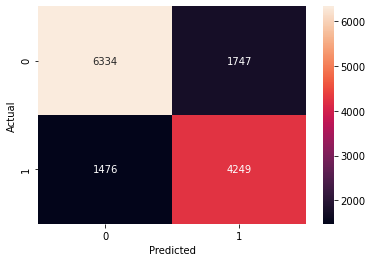

In [149]:
sns.heatmap(rfc_cfm, annot=True, fmt='d');
plt.xlabel('Predicted');
plt.ylabel('Actual');

## Logistic Regression

In [150]:
# Instantiating the Logistic Regression model
lgr = LogisticRegression(random_state=42, n_jobs=2)

# Setting the parameters that need to be cross-validated
lgr_params = {
  'penalty': ['l1', 'l2'],
  'C': [1.0, 10, 100],
}

# Using GridSearch to find the best parameters for the model
lgr_cv = GridSearchCV(estimator=lgr, param_grid=lgr_params, verbose=5)

In [151]:
# Fitting Logistic Regression model onto the training dataset
lgr_cv = lgr_cv.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] C=1.0, penalty=l1 ...............................................
[CV] ....... C=1.0, penalty=l1, score=0.720701144429958, total=   0.2s
[CV] C=1.0, penalty=l1 ...............................................


/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(self.n_jobs))
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2

[CV] ...... C=1.0, penalty=l1, score=0.7162622238319449, total=   0.1s
[CV] C=1.0, penalty=l1 ...............................................
[CV] ...... C=1.0, penalty=l1, score=0.7208982252806954, total=   0.2s
[CV] C=1.0, penalty=l2 ...............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(self.n_jobs))
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 

[CV] ...... C=1.0, penalty=l2, score=0.7206287121541359, total=   0.1s
[CV] C=1.0, penalty=l2 ...............................................
[CV] ...... C=1.0, penalty=l2, score=0.7161897863093082, total=   0.1s
[CV] C=1.0, penalty=l2 ...............................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.6s remaining:    0.0s
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(self.n_jobs))
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2

[CV] ...... C=1.0, penalty=l2, score=0.7208982252806954, total=   0.1s
[CV] C=10, penalty=l1 ................................................
[CV] ....... C=10, penalty=l1, score=0.7206287121541359, total=   0.1s
[CV] C=10, penalty=l1 ................................................


/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(self.n_jobs))
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(self.n_jobs))


[CV] ....... C=10, penalty=l1, score=0.7161897863093082, total=   0.1s
[CV] C=10, penalty=l1 ................................................
[CV] ....... C=10, penalty=l1, score=0.7208982252806954, total=   0.2s
[CV] C=10, penalty=l2 ................................................


/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(self.n_jobs))
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(self.n_jobs))


[CV] ....... C=10, penalty=l2, score=0.7206287121541359, total=   0.1s
[CV] C=10, penalty=l2 ................................................
[CV] ....... C=10, penalty=l2, score=0.7161897863093082, total=   0.1s
[CV] C=10, penalty=l2 ................................................


/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(self.n_jobs))
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(self.n_jobs))


[CV] ....... C=10, penalty=l2, score=0.7208982252806954, total=   0.1s
[CV] C=100, penalty=l1 ...............................................
[CV] ...... C=100, penalty=l1, score=0.7205562798783137, total=   0.1s
[CV] C=100, penalty=l1 ...............................................


/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(self.n_jobs))
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(self.n_jobs))


[CV] ...... C=100, penalty=l1, score=0.7161897863093082, total=   0.1s
[CV] C=100, penalty=l1 ...............................................
[CV] ...... C=100, penalty=l1, score=0.7208982252806954, total=   0.1s
[CV] C=100, penalty=l2 ...............................................


/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(self.n_jobs))
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(self.n_jobs))


[CV] ...... C=100, penalty=l2, score=0.7206287121541359, total=   0.1s
[CV] C=100, penalty=l2 ...............................................
[CV] ...... C=100, penalty=l2, score=0.7161897863093082, total=   0.1s
[CV] C=100, penalty=l2 ...............................................


/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(self.n_jobs))
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(self.n_jobs))


[CV] ...... C=100, penalty=l2, score=0.7208982252806954, total=   0.2s


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    2.5s finished
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(self.n_jobs))


In [152]:
lgr_y_pred = lgr_cv.predict(X_test)

In [153]:
# printing precision, recall and f1-score

print(classification_report(y_test, lgr_y_pred))

             precision    recall  f1-score   support

          0       0.74      0.79      0.76      7810
          1       0.69      0.63      0.66      5996

avg / total       0.72      0.72      0.72     13806



**Interpretation**

The model performs slightly worse than the Random Forest Classifier with an F1-score of 0.72

In [154]:
# Creating confusion matrix
lgr_cfm = confusion_matrix(lgr_y_pred, y_test)

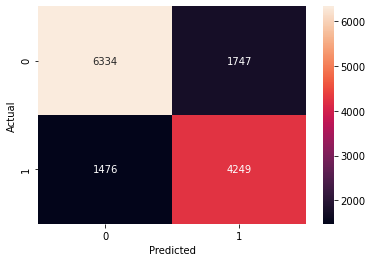

In [155]:
sns.heatmap(rfc_cfm, annot=True, fmt='d');
plt.xlabel('Predicted');
plt.ylabel('Actual');